### 전체 프로세스
1) 도형 중심도 맞추기
-> contounr 찾아 도형 위치 파악 (contour and centroid)
-> 위치 옮기기 (Translation)

2) 도형 주축 맞추기
-> scaling 작업
-> 같은 scale 갖는 도형의 주축 계산 (타원 fitting)
-> 도형을 회전시켜 주축 맞추기

3) 도형 유사도 계산
-> Dice 스코어

In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt

1. 도형 중심도 맞추기

- 1-1. Contour 찾아 도형 위치 파악 및 시각화

Found 2 contours.


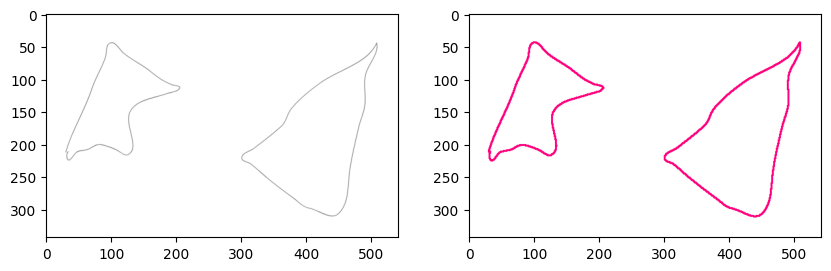

In [2]:
image = cv2.imread("./Lab Assignment 5-input.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} contours.")

image_for_vis = image.copy()
cv2.drawContours(image_for_vis, contours, -2, (255, 0, 125), 2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[1].imshow(image_for_vis)

1. 도형 중심도 맞추기

- 1-2. Contour의 중심점을 기준으로 origin (0, 0)으로 도형 옮긴 후 시각화

In [3]:
def translate_contour_to_origin(contour):
    M = cv2.moments(contour)                    # Calculate the centroid of the contour
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    dx = cX                                     # Calculate the translation vectors
    dy = cY
    translated_contour = contour - [dx, dy]     # Adjust the contour
    return translated_contour
    #controid를 원점으로 이동

(-550.0, 550.0)

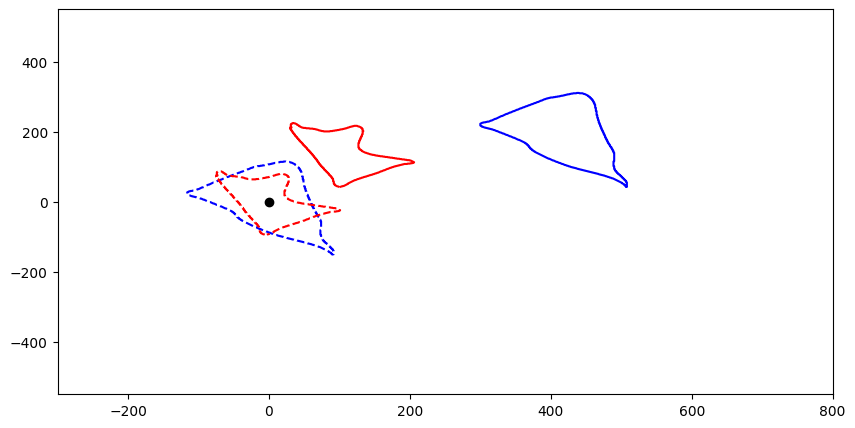

In [4]:
contour1 = contours[0]
contour2 = contours[1]

translated_contour1 = translate_contour_to_origin(contour1)
translated_contour2 = translate_contour_to_origin(contour2)

x1_origin = contour1[:, 0, 0]
y1_origin = contour1[:, 0, 1]
x2_origin = contour2[:, 0, 0]
y2_origin = contour2[:, 0, 1]

x1_translated = translated_contour1[:, 0, 0]
y1_translated = translated_contour1[:, 0, 1]
x2_translated = translated_contour2[:, 0, 0]
y2_translated = translated_contour2[:, 0, 1]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x1_origin, y1_origin, linestyle='-', color='blue')
ax.plot(x2_origin, y2_origin, linestyle='-', color='red')

ax.plot(x1_translated, y1_translated, linestyle='--', color='blue')
ax.plot(x2_translated, y2_translated, linestyle='--', color='red')

ax.scatter(0, 0, c='black')
ax.set_xlim(-300, 800)
ax.set_ylim(-550, 550)

2. 도형 주축 맞추기

- 2-1. origin으로 옮긴 도형 Scaling 하여 범위 맞추기

In [5]:
def normalize_contours(contour):
    x, y, w, h = cv2.boundingRect(contour)          # Calculate the bounding rectangle for each contour

    if w == 0 or h == 0:        # Avoid division by zero
        return

    normalized_contour = []
    for point in contour:
        normalized_point = [(point[0][0]) / w, (point[0][1]) / h]           # normalized_point = [(point[0][0] - x) / w, (point[0][1] - y) / h]
        normalized_contour.append([normalized_point])

    return np.array(normalized_contour, dtype=np.float32)

    #01~1로 scale 맞추기


(-1.0, 1.0)

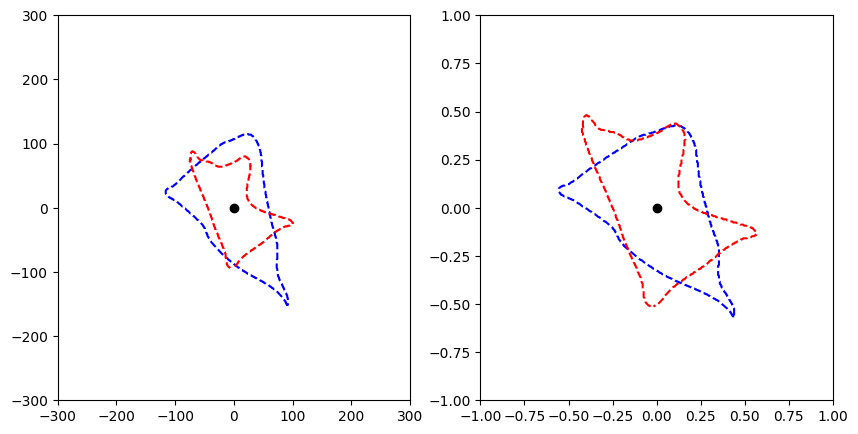

In [6]:
normalized_contour1 = normalize_contours(translated_contour1)
normalized_contour2 = normalize_contours(translated_contour2)

x1_translated = translated_contour1[:, 0, 0]
y1_translated = translated_contour1[:, 0, 1]
x2_translated = translated_contour2[:, 0, 0]
y2_translated = translated_contour2[:, 0, 1]

x1_normalized = normalized_contour1[:, 0, 0]
y1_normalized = normalized_contour1[:, 0, 1]
x2_normalized = normalized_contour2[:, 0, 0]
y2_normalized = normalized_contour2[:, 0, 1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x1_translated, y1_translated, linestyle='--', color='blue')
ax[0].plot(x2_translated, y2_translated, linestyle='--', color='red')
ax[0].scatter(0, 0, c='black')
ax[0].set_xlim(-300, 300)
ax[0].set_ylim(-300, 300)

ax[1].plot(x1_normalized, y1_normalized, linestyle='--', color='blue')
ax[1].plot(x2_normalized, y2_normalized, linestyle='--', color='red')
ax[1].scatter(0, 0, c='black')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)

2. 도형 주축 맞추기

- 2-2. Scaling 한 도형의 주축 구하기 및 시각화

In [13]:
def find_major_axis_degree(contour):
  # Perform PCA to find the principal axis
  
  mean = np.mean(contour, axis=0)                   
  contour_centered = contour - mean
  cov_matrix = np.cov(contour_centered.squeeze().T) 
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) 
  sorted_indices = np.argsort(eigenvalues)[::-1]        
  principal_axis = eigenvectors[:, sorted_indices[0]]   
  angle_radians = np.arctan2(principal_axis[1], principal_axis[0])
  angle_degrees = np.degrees(angle_radians)                   
  deviation_from_vertical = 90 - np.abs(angle_degrees)        

  return principal_axis, angle_degrees, deviation_from_vertical

1번 Contour의 주축 각도 -49.567437918149935, 90도를 기준 기울어진 정도 40.432562081850065
2번 Contour의 주축 각도 -45.47939262616231, 90도를 기준 기울어진 정도 44.52060737383769


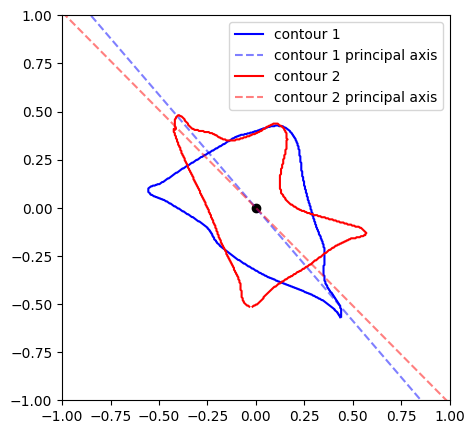

In [14]:
normalized_contour1 = normalize_contours(translated_contour1)
normalized_contour2 = normalize_contours(translated_contour2)

x1_normalized = normalized_contour1[:, 0, 0]
y1_normalized = normalized_contour1[:, 0, 1]
x2_normalized = normalized_contour2[:, 0, 0]
y2_normalized = normalized_contour2[:, 0, 1]

principal_axis1, angle_degrees1, deviation_from_vertical1 = find_major_axis_degree(normalized_contour1)
principal_axis2, angle_degrees2, deviation_from_vertical2 = find_major_axis_degree(normalized_contour2)

m1 = principal_axis1[1] / principal_axis1[0]
y_range1 = m1 * np.array([-1, 1])

m2 = principal_axis2[1] / principal_axis2[0]
y_range2 = m2 * np.array([-1, 1])

print(f'1번 Contour의 주축 각도 {angle_degrees1}, 90도를 기준 기울어진 정도 {deviation_from_vertical1}')
print(f'2번 Contour의 주축 각도 {angle_degrees2}, 90도를 기준 기울어진 정도 {deviation_from_vertical2}')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(x1_normalized, y1_normalized, linestyle='-', color='blue', label='contour 1')
plt.plot(np.array([-1, 1]), y_range1, linestyle='--', alpha = 0.5,  label='contour 1 principal axis', color='blue')


ax.plot(x2_normalized, y2_normalized, linestyle='-', color='red', label='contour 2')
plt.plot(np.array([-1, 1]), y_range2, linestyle='--', alpha = 0.5, label='contour 2 principal axis', color='red')

ax.scatter(0, 0, c='black')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.legend()

2. 도형 주축 맞추기

- 2-3. 주축을 맞추기 위해 회전 진행

In [15]:
def rotate_contour(contour, angle):
    bbox = cv2.boundingRect(contour)            # Calculate the center of the bounding box for the contour
    center_x = bbox[0] + bbox[2] // 2
    center_y = bbox[1] + bbox[3] // 2
    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)     # Compute the rotation matrix for the given angle around the center
    rotated_contour = cv2.transform(contour, rotation_matrix)                       # Perform the rotation on the entire contour
    return rotated_contour

1번 Contour의 주축 각도 -49.567437918149935, 90도를 기준 기울어진 정도 40.432562081850065
2번 Contour의 주축 각도 -45.47939262616231, 90도를 기준 기울어진 정도 44.52060737383769
주축 차이 만큼의 Rotation 진행
1번 Contour의 주축 각도 -45.47939396527612, 90도를 기준 기울어진 정도 44.52060603472388
2번 Contour의 주축 각도 -45.47939262616231, 90도를 기준 기울어진 정도 44.52060737383769


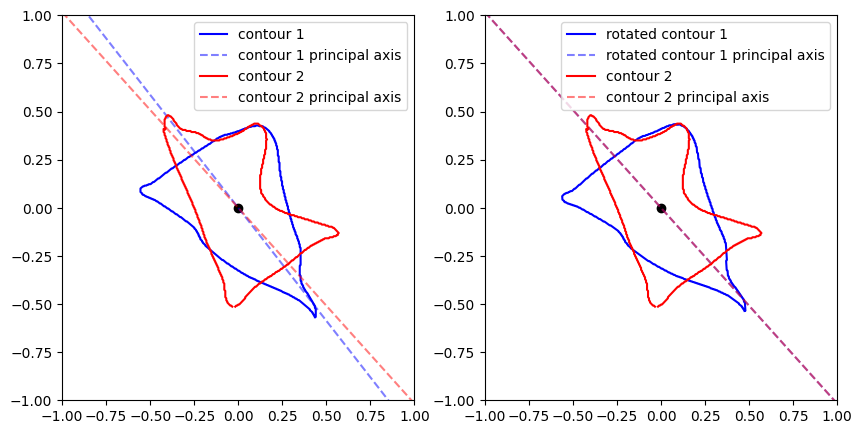

In [16]:
normalized_contour1 = normalize_contours(translated_contour1)
normalized_contour2 = normalize_contours(translated_contour2)

x1_normalized = normalized_contour1[:, 0, 0]
y1_normalized = normalized_contour1[:, 0, 1]
x2_normalized = normalized_contour2[:, 0, 0]
y2_normalized = normalized_contour2[:, 0, 1]

principal_axis1, angle_degrees1, deviation_from_vertical1 = find_major_axis_degree(normalized_contour1)
m1 = principal_axis1[1] / principal_axis1[0]
y_range1 = m1 * np.array([-1, 1])

principal_axis2, angle_degrees2, deviation_from_vertical2 = find_major_axis_degree(normalized_contour2)
m2 = principal_axis2[1] / principal_axis2[0]
y_range2 = m2 * np.array([-1, 1])

print(f'1번 Contour의 주축 각도 {angle_degrees1}, 90도를 기준 기울어진 정도 {deviation_from_vertical1}')
print(f'2번 Contour의 주축 각도 {angle_degrees2}, 90도를 기준 기울어진 정도 {deviation_from_vertical2}')

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x1_normalized, y1_normalized, linestyle='-', color='blue', label='contour 1')
ax[0].plot(np.array([-1, 1]), y_range1, linestyle='--', alpha = 0.5,  label='contour 1 principal axis', color='blue')

ax[0].plot(x2_normalized, y2_normalized, linestyle='-', color='red', label='contour 2')
ax[0].plot(np.array([-1, 1]), y_range2, linestyle='--', alpha = 0.5, label='contour 2 principal axis', color='red')

ax[0].scatter(0, 0, c='black')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()

# Rotate 진행
print('주축 차이 만큼의 Rotation 진행')
rotated_contour1 = rotate_contour(normalized_contour1, angle_degrees1-angle_degrees2)
x1_rotated = rotated_contour1[:, 0, 0]
y1_rotated = rotated_contour1[:, 0, 1]

principal_axis1, angle_degrees1, deviation_from_vertical1 = find_major_axis_degree(rotated_contour1)
m1 = principal_axis1[1] / principal_axis1[0]
y_range1 = m1 * np.array([-1, 1])

print(f'1번 Contour의 주축 각도 {angle_degrees1}, 90도를 기준 기울어진 정도 {deviation_from_vertical1}')
print(f'2번 Contour의 주축 각도 {angle_degrees2}, 90도를 기준 기울어진 정도 {deviation_from_vertical2}')

ax[1].plot(x1_rotated, y1_rotated, linestyle='-', color='blue', label='rotated contour 1')
ax[1].plot(np.array([-1, 1]), y_range1, linestyle='--', alpha = 0.5,  label='rotated contour 1 principal axis', color='blue')

ax[1].plot(x2_normalized, y2_normalized, linestyle='-', color='red', label='contour 2')
ax[1].plot(np.array([-1, 1]), y_range2, linestyle='--', alpha = 0.5, label='contour 2 principal axis', color='red')

ax[1].scatter(0, 0, c='black')
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)

ax[1].legend()

3) 도형 유사도 계산

- Dice 스코어

In [17]:
def contour_to_mask(contour, image_size=100):
    contour_scaled = np.int32((contour + 1) * (image_size // 2))
    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    cv2.drawContours(mask, [contour_scaled], -1, 1, thickness=cv2.FILLED)
    return mask

def calculate_dice_coefficient(contour1, contour2):
    mask1 = contour_to_mask(contour1)
    mask2 = contour_to_mask(contour2)

    intersection = np.logical_and(mask1, mask2)
    dice_coeff = 2.0 * intersection.sum() / (mask1.sum() + mask2.sum())
    return dice_coeff

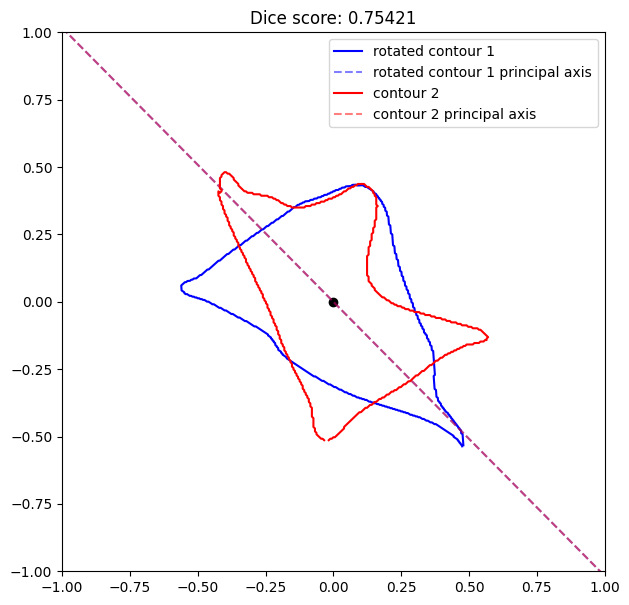

In [18]:
dice = calculate_dice_coefficient(rotated_contour1, normalized_contour2)

plt.figure(figsize=(7,7))
plt.title(f'Dice score: {dice:.5}')

plt.plot(x1_rotated, y1_rotated, linestyle='-', color='blue', label='rotated contour 1')
plt.plot(np.array([-1, 1]), y_range1, linestyle='--', alpha = 0.5,  label='rotated contour 1 principal axis', color='blue')

plt.plot(x2_normalized, y2_normalized, linestyle='-', color='red', label='contour 2')
plt.plot(np.array([-1, 1]), y_range2, linestyle='--', alpha = 0.5, label='contour 2 principal axis', color='red')

plt.scatter(0, 0, c='black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.legend()
plt.show()